## 随机删除10%的细胞 ，富集的细胞类型和组织是否发生较大变化

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import os

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 14

import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [8]:
import os
def makedir(folder_path):
    # 检查文件夹是否已经存在
    if not os.path.exists(folder_path):
        # 文件夹不存在时创建
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 已创建")
    else:
        print(f"文件夹 '{folder_path}' 已存在，不进行任何处理")

In [13]:
# 计算超几何分布pvalue
from scipy.stats import hypergeom
import time
# Fisher's 精确检验
import numpy as np
from scipy.stats import fisher_exact

# core = "peri"
core = "core"
index = "lcczscore"
per = 10  # top10%
trait = 29


for cellsper in range(9):  #细胞比例

    makedir(r"E:\00_CeSOP\results\robust\cell percent\percent%s"%(100-(cellsper+1)*10))
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\lcczscore-pip-coreperi-alltraits\%s\%s\allcells.csv"%(core,trait))
    # 计算需要删除的行数
    num_rows_to_drop = int(len(results_ct) * (cellsper+1)*0.1)
    
    for j in range(100):  #随机次数
        
        # 生成随机索引
        random_indices = np.random.choice(results_ct.index, num_rows_to_drop, replace=False)
        
        # 删除随机选择的行
        results_ct_dropped = results_ct.drop(random_indices)
        results_ct_sorted = results_ct_dropped.sort_values(by=index,ascending=False)
        results_ct_sorted_topk = results_ct_sorted.iloc[:int(len(results_ct_sorted) * (per / 100))][[index,"tissue","celltype","cell"]]
    
        #  计算超几何分布pvalue
        topkcells = set(list(results_ct_sorted_topk["cell"]))
        tissuelist = os.listdir(r"E:\00_CeSOP\results\asthma\lcczscore-pip-cell-sixpoints")
        result_index = []
        for tissue in tissuelist:
            tissue_cell = results_ct[results_ct['tissue']==tissue]
            tissue_cell_topk = results_ct_sorted_topk[results_ct_sorted_topk['tissue']==tissue]
            tissue_cellnum = len(tissue_cell)
            tissue_cellnum_topk = len(tissue_cell_topk)
    
            # 计算fisher精确检验pvalue
            b = tissue_cellnum
            a = tissue_cellnum_topk
            observed_table = [[a, b-a], [np.floor(b/100 * per), b - np.floor(b/100 * per)]]  # 2x2 列联表数据
            odds_ratio, p_value = fisher_exact(observed_table, alternative='greater')
    
            result_index.append([tissue,p_value])
    
        result_index_df = pd.DataFrame(result_index)
        result_index_df.columns = ["tissue","fisher's pvalue"]
        if (j%10 == 0) :
            print(j,time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        result_index_df.to_csv(r"E:\00_CeSOP\results\robust\cell percent\percent%s\top%s_trait%s_%s_ran%s_lcczscore.csv"%((100-(cellsper+1)*10),per,trait,core,j))


文件夹 'E:\00_CeSOP\results\robust\cell percent\percent90' 已存在，不进行任何处理
0 2024-11-30 23:48:15
10 2024-11-30 23:48:29
20 2024-11-30 23:48:41
30 2024-11-30 23:48:56
40 2024-11-30 23:49:09
50 2024-11-30 23:49:25
60 2024-11-30 23:49:40
70 2024-11-30 23:49:57
80 2024-11-30 23:50:12
90 2024-11-30 23:50:30
文件夹 'E:\00_CeSOP\results\robust\cell percent\percent80' 已存在，不进行任何处理
0 2024-11-30 23:50:49
10 2024-11-30 23:51:13
20 2024-11-30 23:51:34
30 2024-11-30 23:51:54
40 2024-11-30 23:52:15
50 2024-11-30 23:52:34
60 2024-11-30 23:52:58
70 2024-11-30 23:53:18
80 2024-11-30 23:53:34
90 2024-11-30 23:53:48
文件夹 'E:\00_CeSOP\results\robust\cell percent\percent70' 已存在，不进行任何处理
0 2024-11-30 23:54:04
10 2024-11-30 23:54:18
20 2024-11-30 23:54:33
30 2024-11-30 23:54:46
40 2024-11-30 23:55:00
50 2024-11-30 23:55:13
60 2024-11-30 23:55:26
70 2024-11-30 23:55:39
80 2024-11-30 23:55:53
90 2024-11-30 23:56:07
文件夹 'E:\00_CeSOP\results\robust\cell percent\percent60' 已创建
0 2024-11-30 23:56:22
10 2024-11-30 23:56:44
20 2

In [62]:
##  随机100次，每次所有组织都有一个显著或者不显著，>50的结果定义为最终的结果
result = pd.DataFrame()
for percent in range(10,100,10):
    print(percent)
    fisher_df  = pd.DataFrame()
    for ran in range(100):
        df = pd.read_csv(r"E:\00_CeSOP\results\robust\cell percent\percent%s\top10_trait29_core_ran%s_lcczscore.csv"%(percent,ran))
        fisher_df = pd.concat([fisher_df,df["fisher's pvalue"]],axis=1)
        
    df = pd.read_csv(r"E:\00_CeSOP\results\robust\cell percent\percent%s\top10_trait29_core_ran0_lcczscore.csv"%percent)    
    fisher_df.columns = [f"Ran{i}" for i in range(100)]
    fisher_df.index = df["tissue"]
    
    # 将小于 0.005 的值设为 1【表示显著相关】，否则设为 0
    fisher_df_01 = (fisher_df < 0.005).astype(int)    
    # 计算每行的和
    row_sums = fisher_df_01.sum(axis=1)    
    # 创建新列，当行和大于50时，将该列的值设置为1【表示显著】，否则为0
    fisher_df_01['New_Column'] = row_sums.apply(lambda x: 1 if x > 50 else 0)
    result = pd.concat([result,fisher_df_01['New_Column']],axis=1)
 
data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
# 使用 apply 来修改值
data["fisher's pvalue new"] = data["fisher's pvalue"].apply(lambda x: 1 if x < 0.005 else 0)
data.index = data["tissue"]
result = pd.concat([result,data["fisher's pvalue new"]],axis=1)   
result.columns = [f"Percent{i}" for i in range(10, 101, 10)]

10
20
30
40
50
60
70
80
90


<AxesSubplot: >

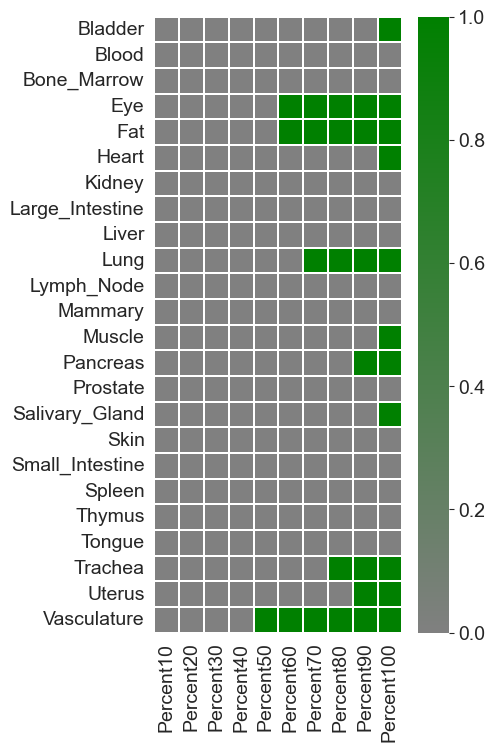

In [71]:
# 使用 seaborn 绘制热图
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# 创建灰色到绿色的自定义颜色映射
colors = [(0, "gray"), (1, "green")]  # (位置, 颜色)，从灰色到绿色
cmap = LinearSegmentedColormap.from_list("gray_green", colors)
plt.figure(figsize=(4, 8))  # 设置图形大小
sns.heatmap(result, cmap=cmap,linewidths = 0.05)

In [43]:
##  随机100次，每次所有组织都有一个显著或者不显著，>50的结果定义为最终的结果
result = pd.DataFrame()
for percent in range(10,100,10):
    print(percent)
    fisher_df  = pd.DataFrame()
    for ran in range(100):
        df = pd.read_csv(r"E:\00_CeSOP\results\robust\cell percent\percent%s\top10_trait29_core_ran%s_lcczscore.csv"%(percent,ran))
        fisher_df = pd.concat([fisher_df,df["fisher's pvalue"]],axis=1)
        
    df = pd.read_csv(r"E:\00_CeSOP\results\robust\cell percent\percent%s\top10_trait29_core_ran0_lcczscore.csv"%percent)    
    fisher_df.columns = [f"Ran{i}" for i in range(100)]
    fisher_df.index = df["tissue"]
    
    # 将小于 0.005 的值设为 1【表示显著相关】，否则设为 0
    fisher_df_01 = (fisher_df < 0.005).astype(int)    
    # 计算每行的和
    row_sums = fisher_df_01.sum(axis=1)    
    # 创建新列，当行和大于50时，将该列的值设置为1【表示显著】，否则为0
    # fisher_df_01['New_Column'] = row_sums.apply(lambda x: 1 if x > 50 else 0)
    result = pd.concat([result,row_sums],axis=1)
result = result/100
 
data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
# # 使用 apply 来修改值
data["fisher's pvalue new"] = data["fisher's pvalue"].apply(lambda x: 1 if x < 0.005 else 0)
data.index = data["tissue"]
result = pd.concat([result,data["fisher's pvalue new"]],axis=1)   
result.columns = [f"Percent{i}" for i in range(10, 101, 10)]
result.to_csv(r"E:\00_CeSOP\results\robust\cell percent\all.csv")

10
20
30
40
50
60
70
80
90


In [44]:
result

,Percent10,Percent20,Percent30,Percent40,Percent50,Percent60,Percent70,Percent80,Percent90,Percent100
Bladder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.11,1
Blood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Bone_Marrow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Eye,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.00,1
Fat,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.00,1
Heart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1
Kidney,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Large_Intestine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Liver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Lung,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00,1.00,1


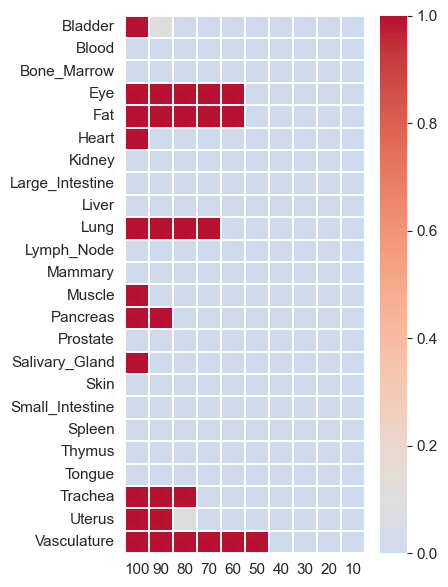

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LinearSegmentedColormap
epsilon = 1e-10
result = pd.read_csv(r"E:\00_CeSOP\results\robust\cell percent\all.csv",index_col=0)
# result_log = -np.log10(result+epsilon)
result.columns = [f"{i}" for i in range(10, 101, 10)]

plt.rcParams['font.size'] = 11
plt.figure(figsize=(4.5, 6))  # 设置图形大小
# x = -np.log10(0.005 + epsilon)
g = sns.heatmap(result[result.columns[::-1]], cmap='coolwarm', linewidths = 0.05, 
                center = 0.1,alpha = 0.95,
                cbar_kws={
                # 'orientation': 'horizontal',  # 色条的方向为水平
                'shrink': 1,                # 色条缩小为 80%
                'aspect': 20,                 # 色条的长宽比
                # 'label': 'Value',             # 色条标签
                # 'ticks': [math.floor(result_log.values.min()), x, math.ceil(result_log.values.max())]           # 设置色条的刻度
            }
                )

plt.tight_layout()
plt.savefig(r"E:\00_CeSOP\results\robust\cell_percent.png")
plt.show()

<Figure size 400x100 with 0 Axes>

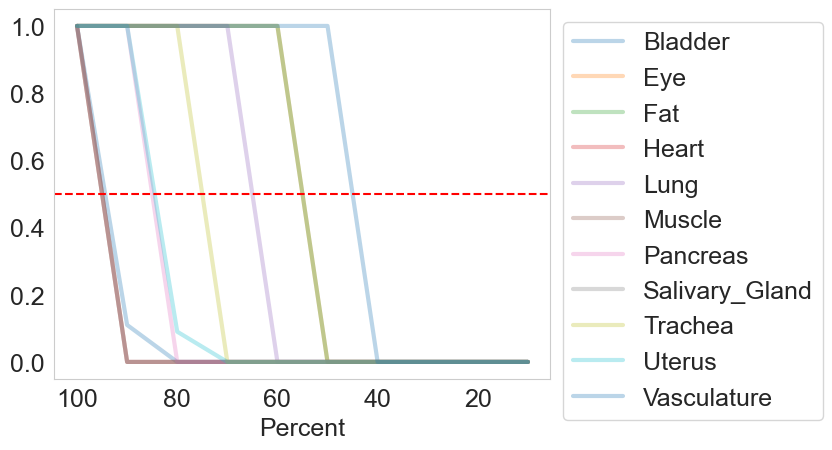

In [36]:
data = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\29\top10_core_lcczscore.csv")
# 筛选 col1 列值小于 0.005 的行
filtered_list = list(data[data["fisher's pvalue"] < 0.005]["tissue"])
result = pd.read_csv(r"E:\00_CeSOP\results\robust\cell percent\all.csv",index_col=0)
result_filtered_df = result[result.index.isin(filtered_list)]
# fisher_df = pd.DataFrame()
# for per in range(10,100,10):
#     df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(per,trait,core))
#     # 筛选 col1 列的值在 value_list 中的行
#     filtered_df = df[df['tissue'].isin(filtered_list)]
#     filtered_df["log fisher's pvalue"] = -np.log10(filtered_df["fisher's pvalue"] + epsilon)
#     fisher_df = pd.concat([fisher_df,filtered_df["log fisher's pvalue"]],axis=1)
# fisher_df.index = filtered_list
result_filtered_df.columns = [f"{i}" for i in range(10, 101, 10)]

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 18
plt.figure(figsize=(4, 1))
ax = result_filtered_df[result_filtered_df.columns[::-1]].T.plot(linestyle='-', linewidth=3,alpha=0.3,ylabel="",xlabel = "Percent")
plt.grid(False)
# 显示图形
# 设置图例在图表外部
# 添加横线
plt.axhline(y=0.5, color='red', linestyle='--')

# 添加竖线
# plt.axvline(x=4, color='blue', linestyle='--')

# 显示图例
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

In [27]:
result

,Percent10,Percent20,Percent30,Percent40,Percent50,Percent60,Percent70,Percent80,Percent90,Percent100
Bladder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.11,1
Blood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Bone_Marrow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Eye,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.00,1
Fat,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.00,1
Heart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1
Kidney,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Large_Intestine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Liver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0
Lung,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00,1.00,1
